In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import models as m
from sim_data import residuals
import likelihood as l

import miscMCMC.samplers.jax_ptmcmc as ptmcmc

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

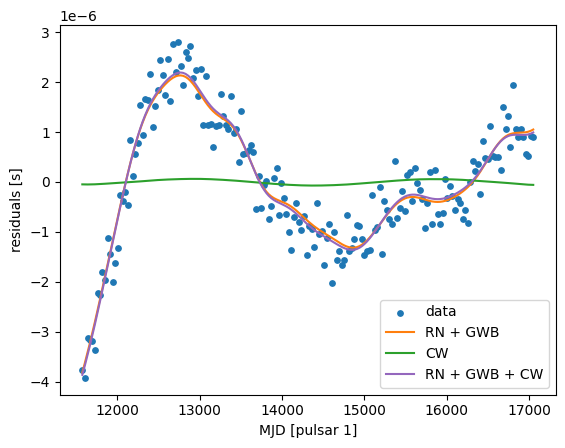

In [2]:
# plot data and injected signals
psr_ndx = 0
plt.scatter(m.MJDs[psr_ndx], m.Rs[psr_ndx] @ residuals[psr_ndx], color='C0', s=15, label='data')
if m.model_gwb or m.model_rn:
    rn_gwb_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.a_inj.reshape((m.Np, m.Na))[psr_ndx]
    plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if m.model_cw:
    cw_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.get_CW_coefficients(m.x_inj[m.cw_psr_ndxs])[psr_ndx]
    plt.plot(m.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (m.model_gwb or m.model_rn) and m.model_cw:
    plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [3]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[m.efac_ndxs]
    rn_hypers = x[m.rn_ndxs]
    gwb_hypers = x[m.gwb_ndxs]
    cw_psr_params = x[m.cw_psr_ndxs]
    psr_dists = x[m.psr_dist_ndxs]
    a = x[m.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn_gwb(rn_hypers, gwb_hypers, a)
    lnprior_val += l.psr_dist_lnprior(psr_dists)

    # likelihood
    a_cw = m.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(efacs, a + a_cw)

    return lnprior_val + lnlike_val

vectorized_lnpost = jit(vmap(lnpost))

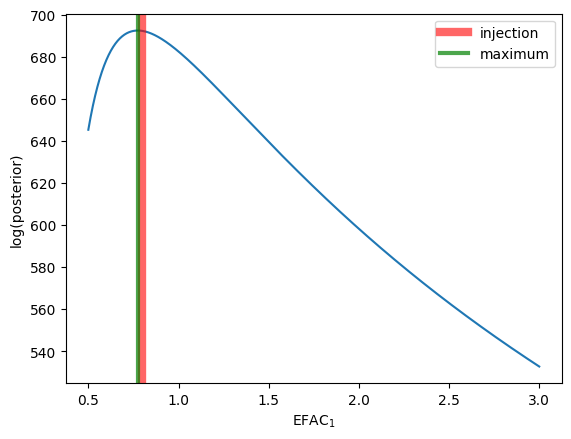

In [4]:
# plot cross-section of posterior
param_ndx = 0
num_evals = 1000
param_vals = jnp.linspace(m.x_mins[param_ndx], m.x_maxs[param_ndx], num_evals)
params = jnp.tile(m.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(m.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(m.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [5]:
@jit
def pt_lnpost(x, temperature=1.):
    return lnpost(x) / temperature

In [6]:
num_samples = int(1e6)
num_chains = 30
states, lnposts, temperature_ladder = ptmcmc.ptmcmc_sampler(num_samples=int(1e6),
                                                            num_chains=num_chains,
                                                            logpdf_func=pt_lnpost,
                                                            x0=m.x_inj,
                                                            x_mins=m.x_mins,
                                                            x_maxs=m.x_maxs,
                                                            temperature_ladder=1.15**jnp.arange(num_chains),
                                                            Fisher_update_rate=0.01,
                                                            Fisher_jump_weight=3.,
                                                            DE_jump_weight=0.,
                                                            PT_swap_weight=1.,
                                                            seed=11)

jump acceptance rates

Fisher: [0.56700003 0.58400005 0.601      0.62200004 0.63600004 0.65300006
 0.67600006 0.694      0.707      0.72       0.73200005 0.74300003
 0.757      0.77400005 0.78900003 0.80500007 0.81600004 0.82100004
 0.82800007 0.83400005 0.837      0.84200007 0.845      0.84900004
 0.851      0.85300004 0.85300004 0.85600007 0.85800004 0.86200005]

DE: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]

PT swap: [0.34       0.33       0.37300003 0.374      0.37800002 0.328
 0.30400002 0.38500002 0.37100002 0.36800003 0.367      0.31
 0.32700002 0.284      0.33800003 0.395      0.39600003 0.42700002
 0.44500002 0.469      0.485      0.51500005 0.527      0.48600003
 0.45700002 0.46400002 0.558      0.503      0.53000003        nan]



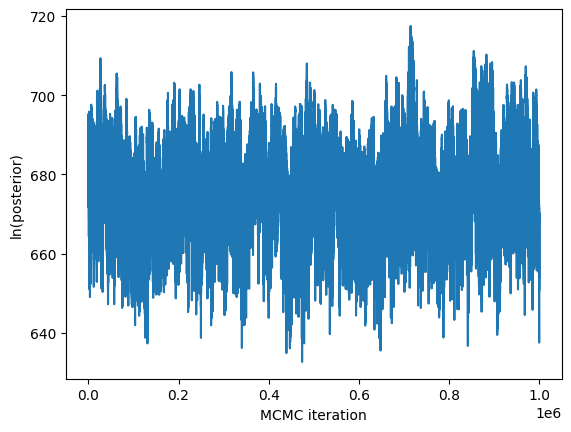

In [7]:
# plot posterior values
plt.plot(lnposts[:, 0])
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.show()

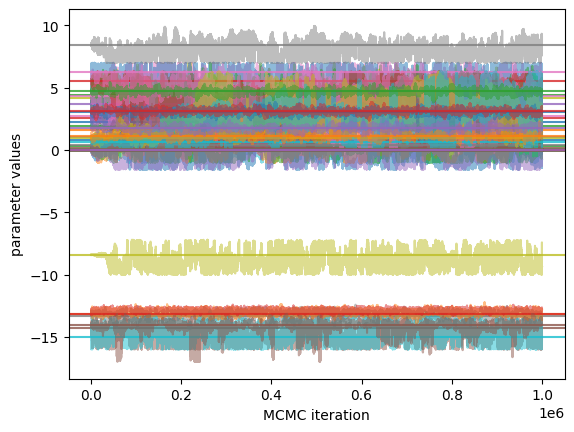

In [12]:
# trace plot
for i in range(m.ndim):
    plt.plot(states[:, 0, i], color=f'C{i}', alpha=0.5)
    plt.axhline(m.x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.show()

In [13]:
# plot auto-correlations
auto_corrs = np.array([integrated_time(states[:, 0, i])[0] for i in range(m.ndim)])
plt.bar(np.arange(m.ndim), auto_corrs)
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20000;
tau: [20043.72730788]

Parameter $\log_{10}\,A_{1}$ in chain HMC is not constrained
Parameter $\gamma_{1}$ in chain HMC is not constrained


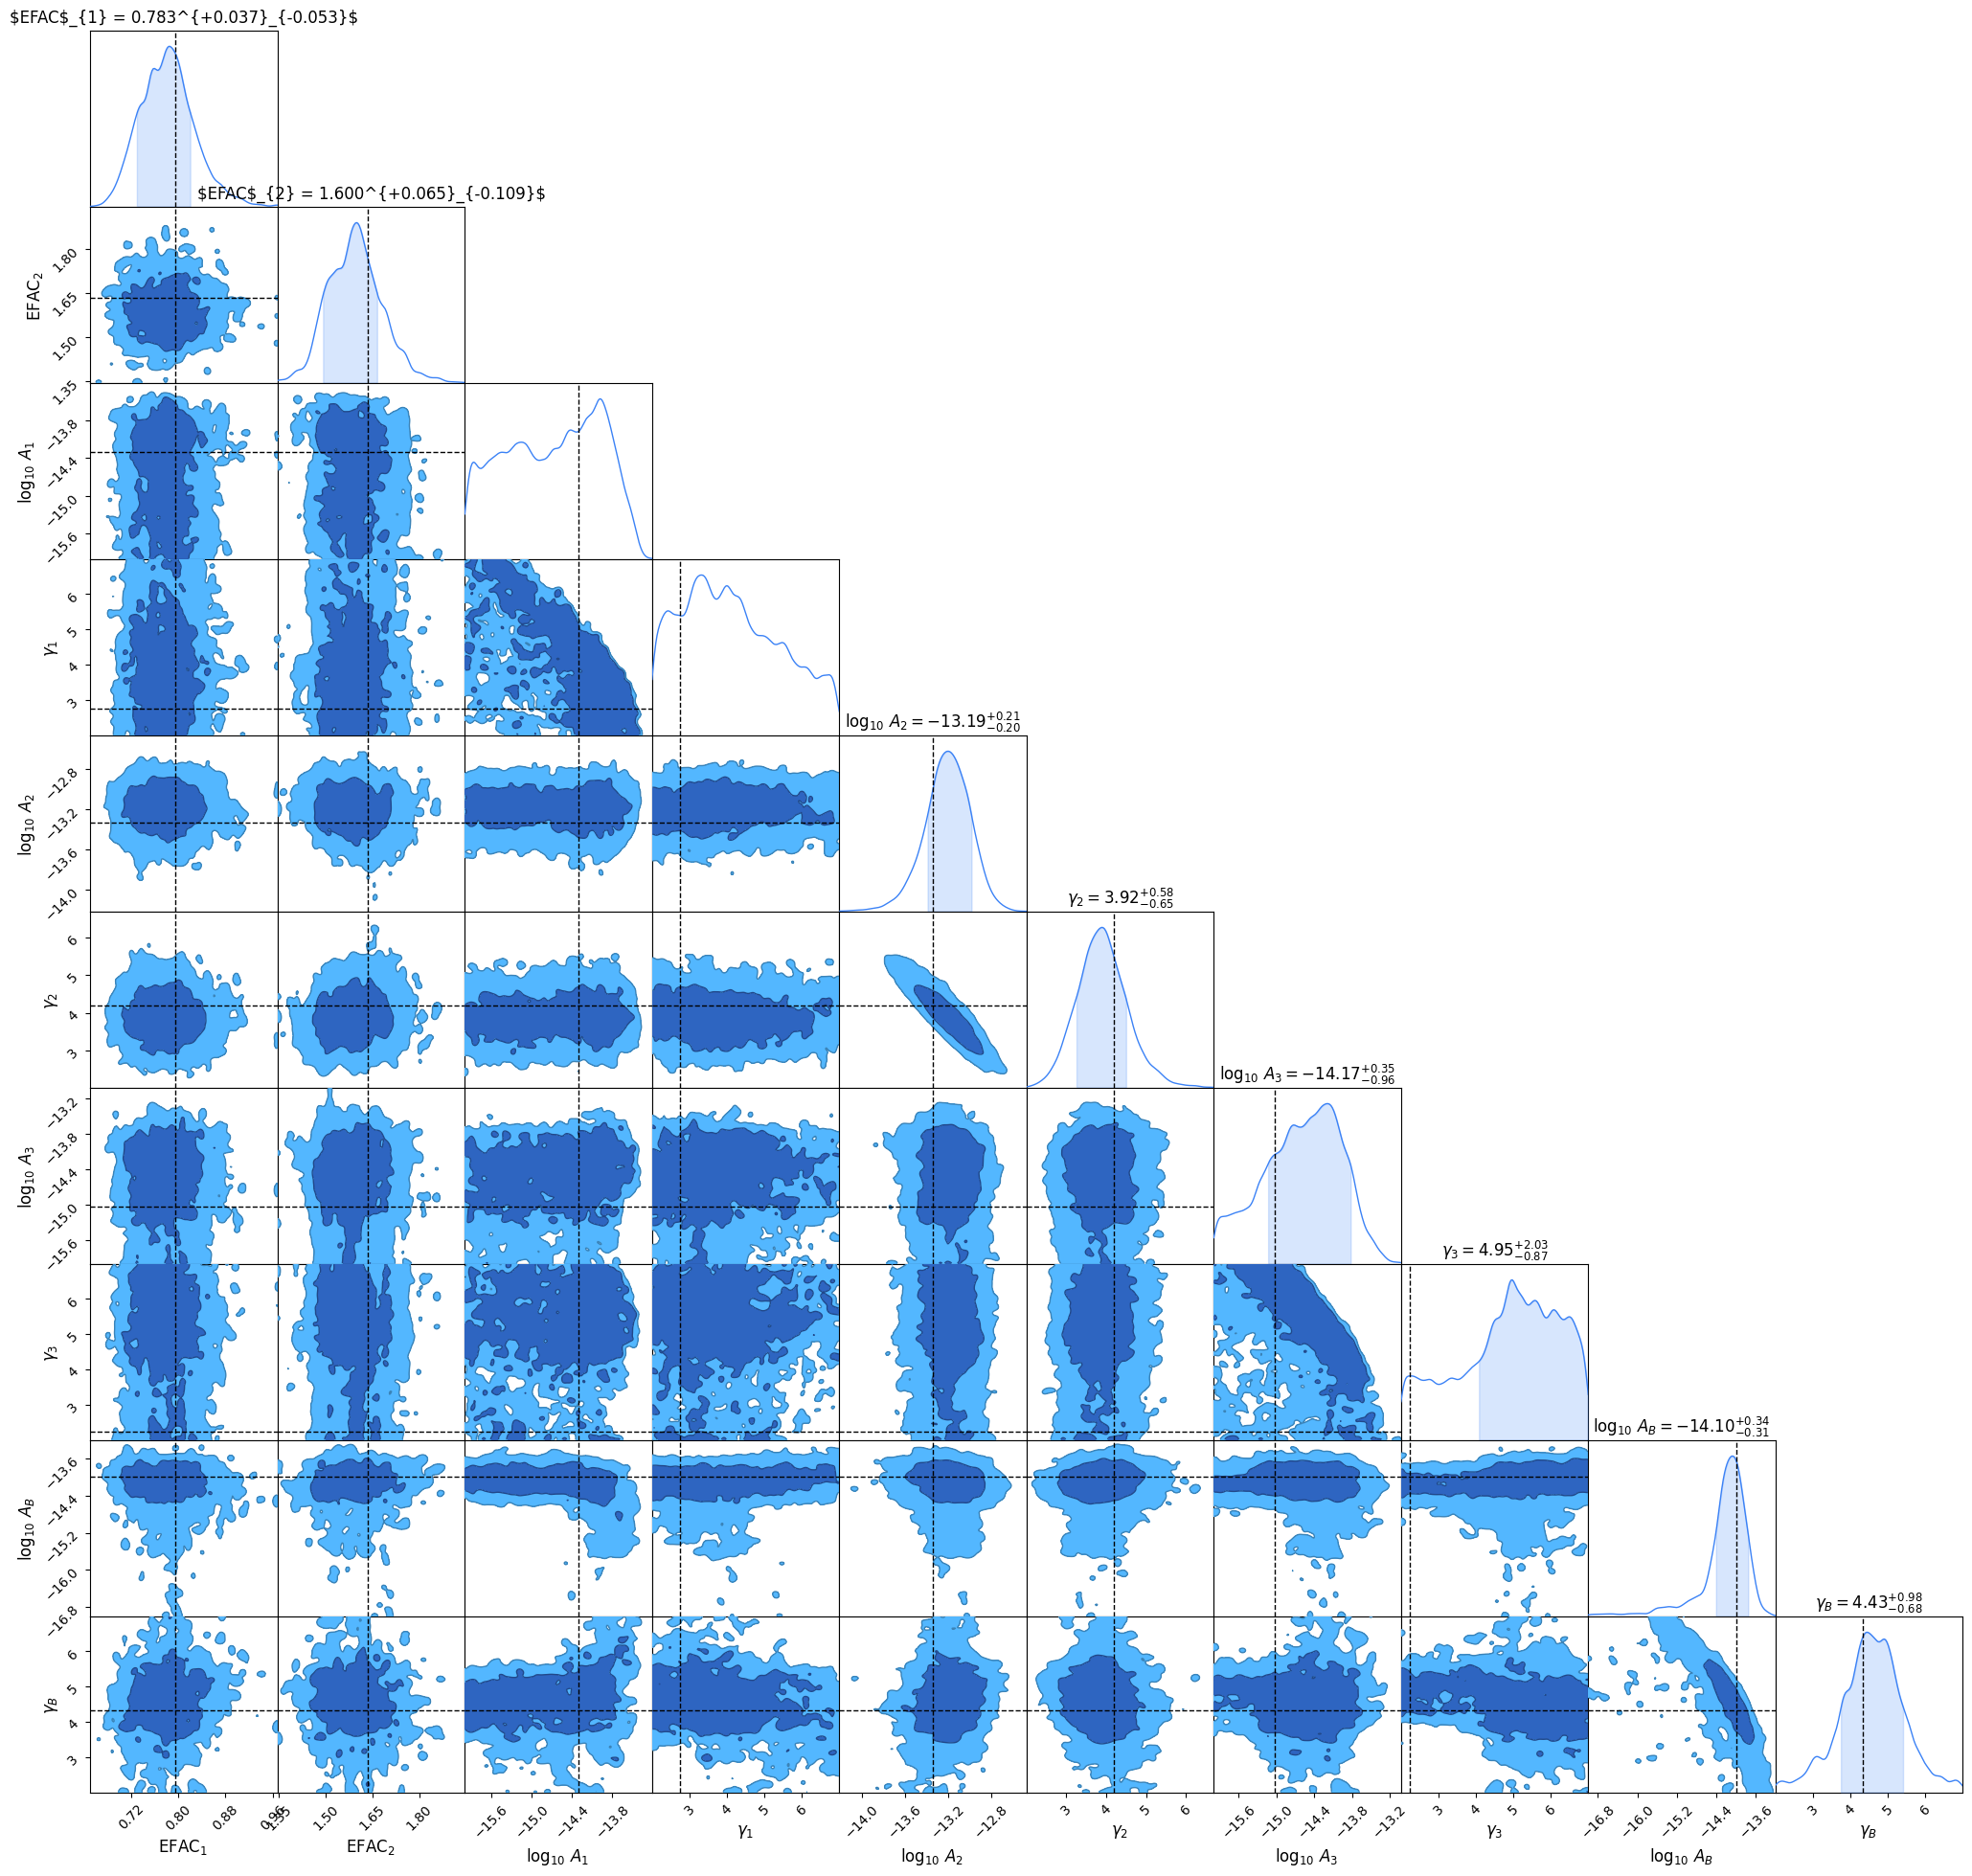

In [ ]:
# corner plot
ndxs = np.concatenate((m.efac_ndxs[:2], m.rn_ndxs[:6], m.gwb_ndxs))
df = pd.DataFrame(states[num_samples//10::1, 0], columns=m.x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(m.x_labels, m.x_inj)}))
fig = c.plotter.plot()

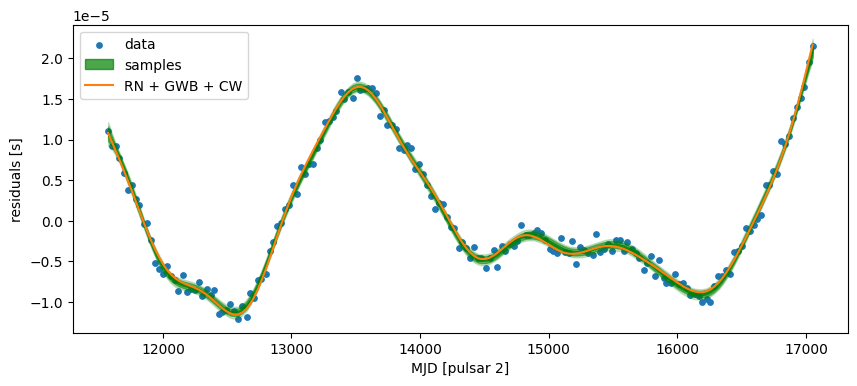

In [16]:
# Bayesogram
psr_ndx = 1
fair_draw_ndxs = np.random.choice(samples.shape[0], (1000,))
a_cws = np.array([m.get_CW_coefficients(samples[ndx, m.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
signals = np.array([m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ (samples[ndx, m.a_ndxs].reshape((m.Np, m.Na))[psr_ndx] + a_cw)
                    for ndx, a_cw in zip(fair_draw_ndxs, a_cws)])

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(m.MJDs[psr_ndx], m.Rs[psr_ndx] @ residuals[psr_ndx], color='C0', s=15, label='data')
plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
                 color='green', alpha=0.2)
plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
                 color='green', alpha=0.5)
plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
                 color='green', alpha=0.7, label='samples')
rn_gwb_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.a_inj.reshape((m.Np, m.Na))[psr_ndx]
cw_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.get_CW_coefficients(m.x_inj[m.cw_psr_ndxs])[psr_ndx]
plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C1', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()